# 🎵 스포티파이 트랙 분석

Data Preprocessing/Feature Engineering

> EPOCH 3RD 한우림

> 2025.09.05. Fri

1. 주제: **노래 특성을 통한 곡 분류**

> 목표: 어떤 특성을 가진 음악이 사람들에게 인기가 많은지 파악하기

2. 분석 목적
- 인기도 예측 요인 식별: 어떤 음악적 특성들이 곡의 인기도를 결정하는 데 가장 중요한 역할을 하는지 분석
- 모델 구축 및 평가: 데이터를 활용하여 실제 예측 모델을 만들고, 이 모델의 성능을 객관적으로 평가


3. 기대 인사이트
- 주요 예측 변수: `popularity`를 예측하는 데 가장 큰 영향을 미치는 오디오 피처들을 순서대로 나열
- 장르별 인기도 차이: 특정 장르가 다른 장르에 비해 높은 인기를 얻는 경향이 있는지 파악

4. 분석 방법
- EDA
- 데이터 전처리: 결측치, 이상치, Log-Transformation, 스케일링
- 피처 엔지니어링: 어떤 피처를 예측 모델에 포함시킬지 선택
- 모델링 & 모델 선택
- 성능 평가
- 하이퍼파라미터 튜닝
- Feature Importance

## 라이브러리 및 데이터 불러오기, 확인

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('dataset.csv', index_col=0)

In [3]:
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           114000 

- 114,000개의 로우, 20개의 컬럼
- `artists`, `album_name`, `track_name`에 각 1개씩 결측치 존재

1. object (5): `track_id`, `artists`, `album_name`, `track_name`, `track_genre`
    > 트랙에 대한 기본적인 정보
2. int/float (14): `popularity`, `duration_ms`, `dancability`, `energy`, `key`, `loudness`, `mode`, `speechiness`, `acousticness`, `instrumentalness`, `liveness`, `valence`, `tempo`, `time_signauture`
    > 트랙의 오디오 피처
3. bool (1): `explicit`
    > 트랙 가사의 explicit 포함 여부

1. `track_id`: 곡의 고유 ID
2. `artists`: 아티스트 이름; 여러 명일 경우 세미콜론(;)으로 구분
3. `album_name`: 곡이 수록된 앨범 이름
4. `track_name`: 곡 이름
5. `popularity`: 0부터 100까지의 인기도 점수; 높을수록 인기가 많음
6. `duration_ms`: 곡의 길이(밀리초)
7. `explicit`: 선정적인 가사 유무 (True/False)
8. `danceability`: 0.0에서 1.0까지의 댄스 적합성
9. `energy`: 0.0에서 1.0까지의 에너지 및 강도
10. `key`: 곡의 키; 숫자로 표현됨
11. `loudness`: 곡의 전체적인 음량(데시벨)
12. `mode`: 곡의 장조(1) 또는 단조(0) 여부
13. `speechiness`: 0.0에서 1.0까지의 곡 내 음성 비중
14. `acousticness`: 0.0에서 1.0까지의 어쿠스틱성
15. `instrumentalness`: 0.0에서 1.0까지의 보컬 부재 여부
16. `liveness`: 0.0에서 1.0까지의 라이브 공연 가능성
17. `valence`: 0.0에서 1.0까지의 음악적 긍정성
18. `tempo`: 곡의 빠르기(BPM)
19. `time_signature`: 3/4, 4/4와 같은 박자
20. `track_genre`: 곡의 장르

## 데이터 전처리

### 결측치 처리

In [5]:
# 결측치 로우 확인
df[df.isnull().any(axis=1)]

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0,False,0.501,0.583,7,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


row 65900 에 `artists`, `album_name`, `track_name` NaN값\
-> 데이터 로우 개수가 약 11만개로 적지 않음. 하나를 삭제해도 유의한 영향을 주지 않을 것으로 예상

> 해당 로우 삭제하기

In [6]:
# 결측치 삭제
df.drop(df[df.isnull().any(axis=1)].index, inplace=True)

In [7]:
df.isnull().sum()

track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

### 중복값 처리

In [8]:
# 중복값 유무 확인

df.duplicated().sum()

np.int64(450)

In [9]:
df = df.drop_duplicates()
df.shape

(113549, 20)

In [10]:
df.tail()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.235,5,-16.393,1,0.0422,0.640,0.928,0.0863,0.0339,125.995,5,world-music
113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.117,0,-18.318,0,0.0401,0.994,0.976,0.1050,0.0350,85.239,4,world-music
113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.329,0,-10.895,0,0.0420,0.867,0.000,0.0839,0.7430,132.378,4,world-music
113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.506,7,-10.889,1,0.0297,0.381,0.000,0.2700,0.4130,135.960,4,world-music
113999,2hETkH7cOfqmz3LqZDHZf5,Cesária Evora,Miss Perfumado,Barbincor,22,241826,False,0.526,0.487,1,-10.204,0,0.0725,0.681,0.000,0.0893,0.7080,79.198,4,world-music


중복되는 로우 450개를 drop 해서 총 113,549개의 로우만 존재하는데, index는 drop 이전과 동일함
> 인덱스 초기화하자

### 인덱스 초기화

In [11]:
df.reset_index(drop=True, inplace=True)
df.tail()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
113544,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.235,5,-16.393,1,0.0422,0.640,0.928,0.0863,0.0339,125.995,5,world-music
113545,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.117,0,-18.318,0,0.0401,0.994,0.976,0.1050,0.0350,85.239,4,world-music
113546,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.329,0,-10.895,0,0.0420,0.867,0.000,0.0839,0.7430,132.378,4,world-music
113547,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.506,7,-10.889,1,0.0297,0.381,0.000,0.2700,0.4130,135.960,4,world-music
113548,2hETkH7cOfqmz3LqZDHZf5,Cesária Evora,Miss Perfumado,Barbincor,22,241826,False,0.526,0.487,1,-10.204,0,0.0725,0.681,0.000,0.0893,0.7080,79.198,4,world-music


### `tempo` 범주화

In [12]:
# 템포 구간 정의
bins = [0, 90, 120, 150, 200]
labels = ['slow', 'medium', 'fast', 'very_fast']

df['tempo_category'] = pd.cut(df['tempo'], bins=bins, labels=labels, right=False)
df['tempo_category']

0              slow
1              slow
2              slow
3         very_fast
4            medium
            ...    
113544         fast
113545         slow
113546         fast
113547         fast
113548         slow
Name: tempo_category, Length: 113549, dtype: category
Categories (4, object): ['slow' < 'medium' < 'fast' < 'very_fast']

In [13]:
df['tempo_category'].value_counts()

tempo_category
fast         40638
medium       36774
very_fast    19279
slow         16281
Name: count, dtype: int64

In [14]:
# 원-핫 인코딩 적용
df = pd.get_dummies(df, columns=['tempo_category'], prefix='tempo', drop_first=True)

In [15]:
df

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,tempo_medium,tempo_fast,tempo_very_fast
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,False,False,False
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic,False,False,False
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,False,False,False
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,False,False,True
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113544,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,5,...,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music,False,True,False
113545,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,0,...,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music,False,False,False
113546,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,0,...,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music,False,True,False
113547,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,7,...,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music,False,True,False


### `track_genre` 범주화

In [16]:
genre_to_category = {
    # EDM
    'edm': 'Electronic Dance Music', 
    'house': 'Electronic Dance Music', 
    'electro': 'Electronic Dance Music', 
    'trance': 'Electronic Dance Music', 
    'techno': 'Electronic Dance Music', 
    'dubstep': 'Electronic Dance Music', 
    'drum-and-bass': 'Electronic Dance Music', 
    'deep-house': 'Electronic Dance Music', 
    'detroit-techno': 'Electronic Dance Music', 
    'minimal-techno': 'Electronic Dance Music', 
    'progressive-house': 'Electronic Dance Music', 
    'breakbeat': 'Electronic Dance Music',
    
    # Rock
    'alt-rock': 'Rock', 
    'rock': 'Rock', 
    'indie': 'Rock', 
    'indie-pop': 'Rock', 
    'punk': 'Rock', 
    'punk-rock': 'Rock', 
    'hard-rock': 'Rock', 
    'metal': 'Rock', 
    'heavy-metal': 'Rock', 
    'black-metal': 'Rock', 
    'death-metal': 'Rock', 
    'grunge': 'Rock',
    
    # Hip-Hop and R&B
    'hip-hop': 'Hip-Hop and R&B', 
    'r-n-b': 'Hip-Hop and R&B', 
    'trap': 'Hip-Hop and R&B',
    
    # Pop
    'pop': 'Pop', 
    'electro-pop': 'Pop', 
    'synth-pop': 'Pop', 
    'k-pop': 'Pop', 
    'pop-film': 'Pop', 
    'power-pop': 'Pop',
    
    # Latin & Reggae/Dancehall
    'latin': 'Latin & Reggae/Dancehall', 
    'reggaeton': 'Latin & Reggae/Dancehall', 
    'salsa': 'Latin & Reggae/Dancehall', 
    'samba': 'Latin & Reggae/Dancehall', 
    'reggae': 'Latin & Reggae/Dancehall', 
    'dancehall': 'Latin & Reggae/Dancehall',
    
    # Funk and Disco
    'funk': 'Funk and Disco', 
    'disco': 'Funk and Disco', 
    'groove': 'Funk and Disco',
}

df['music_category'] = df['track_genre'].apply(lambda x: genre_to_category.get(x, 'Others'))

In [17]:
df['music_category'].unique()

array(['Others', 'Rock', 'Electronic Dance Music',
       'Latin & Reggae/Dancehall', 'Funk and Disco', 'Hip-Hop and R&B',
       'Pop'], dtype=object)

In [18]:
df['music_category'].value_counts()

music_category
Others                      73627
Rock                        11984
Electronic Dance Music      11976
Latin & Reggae/Dancehall     5987
Pop                          4986
Funk and Disco               2998
Hip-Hop and R&B              1991
Name: count, dtype: int64

### 피처 선정 이유

1. **Audio Features**
- 객관적인 오디오 특성 지표들을 활용하자
- 선정 피처: `danceability`, `energy`, ~~`loudness`~~, `speechiness`, ~~`acousticness`~~, `instrumentalness`, `liveness`, `valence`, `tempo`, `duration_ms`
    - `loudness, energy, acousticness`: 모두 오디오 크기나 에너제틱한 정도를 나타내는 변수들로 높은 상관관계를 보임. 셋 중 `energy`이 가장 큰 범주로 곡의 '에너제틱함'을 보여 줌
    > `energy`만 선택하여 사용

    > `tempo`: '느림', '보통', '빠름', '매우 빠름'으로 범주화
- 곡의 분위기, 리듬, 구성 등을 수치화한 것 -> 음악적 유사성을 파악하는 데 가장 적합하다고 판단


2. **범주형 변수 `explicit`**
- 선정적 가사 유무
- 사회적, 문화적 트렌드에 따라 인기도에 영향을 줄 수 있음

3. (DROP) **Additional Features**
> 오디오 특성 외에 음악의 구조적 특징을 나타내는 피처
- `key`, `mode`, `time_signature`
    - `key`, `mode`: 곡의 음계적 특징 -> 클래식이나 재즈처럼 특정 키를 중심으로 전개되는 곡들을 군집화
    - `time_signature`: 리듬의 기본 구조가 유사한 곡들을 구분 e.g., 3/4박자(왈츠)나 4/4박자
> 곡의 인기도와 직접적인 상관관계가 있지 않을 것으로 예상

> 너무 많은 피처를 사용하면 과적합 발생 가능성 존재

### `explicit` 데이터 인코딩

In [19]:
df['explicit'] = df['explicit'].astype(int)

In [20]:
df['explicit'].value_counts()

explicit
0    103831
1      9718
Name: count, dtype: int64

### Feature Selection

In [21]:
# 예측에 사용할 피처(독립 변수) 리스트 정의
features = ['danceability', 'energy', 'speechiness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'duration_ms', 'explicit', 'tempo_medium', 'tempo_fast', 'tempo_very_fast']

In [22]:
# 선택한 특성들만 포함하는 새로운 데이터프레임 생성
df_features = df[features]

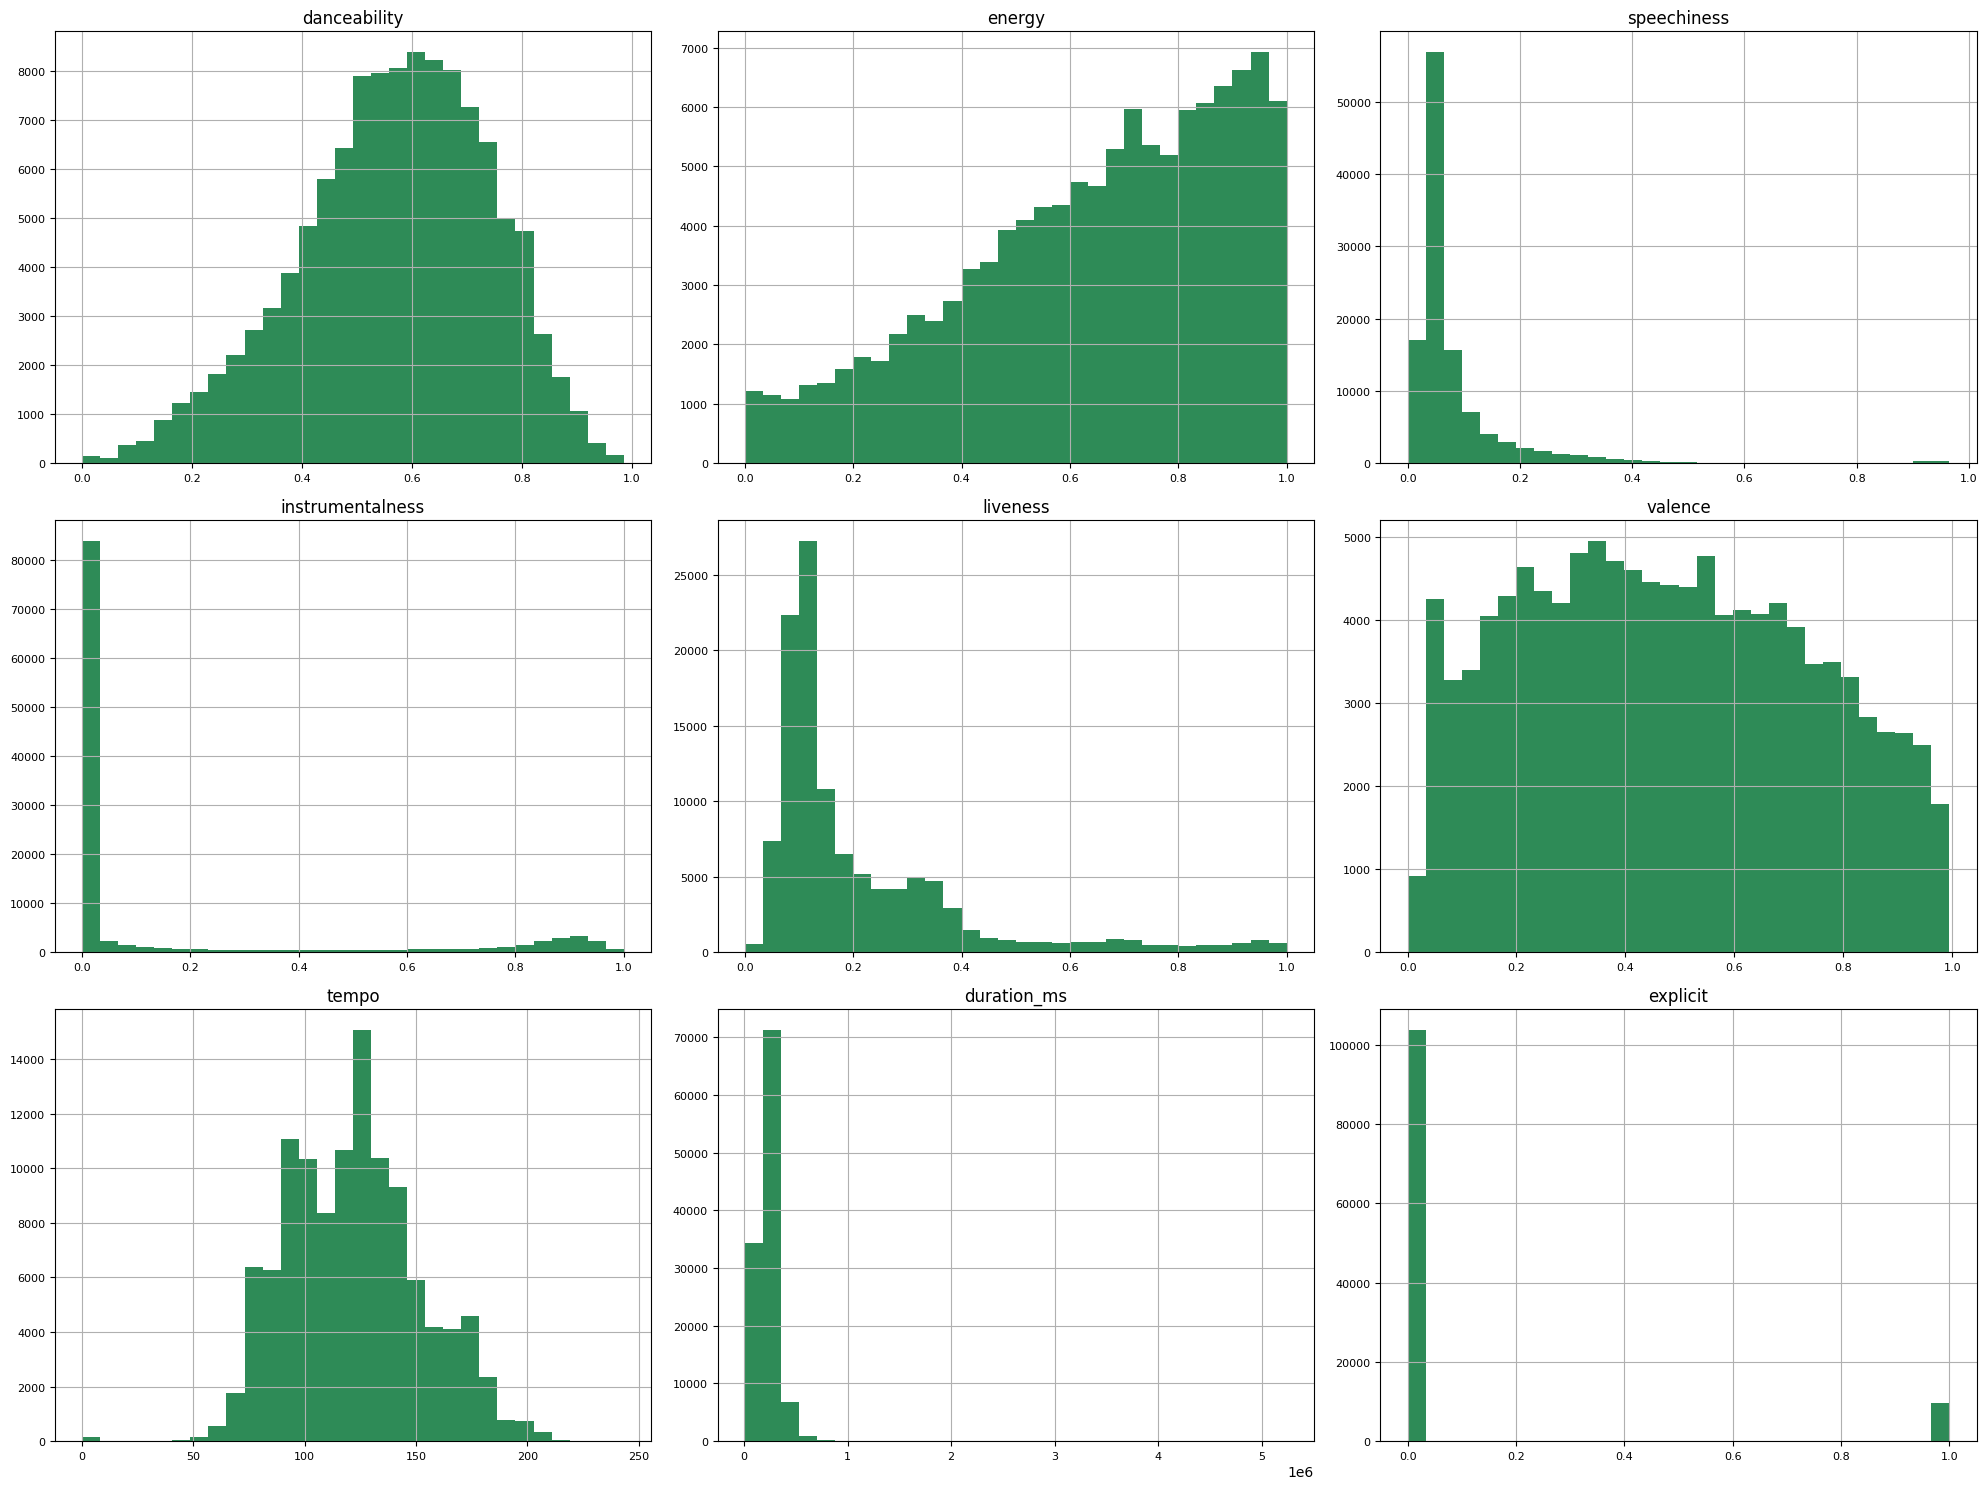

In [23]:
df_features.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8, color='seagreen')
plt.tight_layout()
plt.show()

- standard scaling: `tempo`
- log transform. -> standard scaling
    - `duration_ms`: 비대칭, 값의 범위가 매우 다양함
    - `speechiness`, `instrumentalness`, `liveness`: 비대칭적 분포
- 이외에는 0과 1 사이의 범위를 가지며 치우쳐져 있지 않은 변수 -> No scaling
    - `explicit`: 0과 1 값만 존재

### 예상

위 피처들이 사실상 선형적인 관계로 곡의 인기도에 영향을 줄 것 같지 않음

> 선형 회귀 모델의 성능이 매우 낮게 나올 것으로 예상

> 전처리 연습 겸 선형 회귀를 위한 로그 변환, 스케일링을 해 보자

### Log-Transformation

 EDA 과정에서 오른쪽으로 꼬리가 긴 분포를 가진 변수를 확인할 수 있었음

> `duration_ms`, `speechiness`, `instrumentalness`, `liveness` 로그 변환

In [24]:
# 피처 엔지니어링을 위해 데이터 카피
df_featured = df_features.copy()

# 로그 변환을 적용할 피처
log_features = ['duration_ms', 'speechiness', 'instrumentalness', 'liveness']

In [25]:
# 로그 변환
for feature in log_features:
    df_featured[f'{feature}_log'] = np.log1p(df_featured[feature])
    df_featured = df_featured.drop(columns=[feature]) # 원본 피처 삭제

In [26]:
df_featured

,danceability,energy,valence,tempo,explicit,tempo_medium,tempo_fast,tempo_very_fast,duration_ms_log,speechiness_log,instrumentalness_log,liveness_log
0,0.676,0.4610,0.7150,87.917,0,False,False,False,12.348730,0.133656,0.000001,0.306013
1,0.420,0.1660,0.2670,77.489,0,False,False,False,11.915794,0.073529,0.000006,0.096219
2,0.438,0.3590,0.1200,76.332,0,False,False,False,12.258793,0.054204,0.000000,0.110647
3,0.266,0.0596,0.1430,181.740,0,False,False,True,12.215696,0.035657,0.000071,0.123986
4,0.618,0.4430,0.1670,119.949,0,True,False,False,12.200326,0.051263,0.000000,0.079643
...,...,...,...,...,...,...,...,...,...,...,...,...
113544,0.172,0.2350,0.0339,125.995,0,False,True,False,12.860999,0.041334,0.656483,0.082777
113545,0.174,0.1170,0.0350,85.239,0,False,False,False,12.861001,0.039317,0.681075,0.099845
113546,0.629,0.3290,0.7430,132.378,0,False,True,False,12.511596,0.041142,0.000000,0.080566
113547,0.587,0.5060,0.4130,135.960,0,False,True,False,12.556356,0.029267,0.000000,0.239017


### Scaling

 선형 회귀 모델을 위한 스케일링 과정

In [27]:
scaling_features = ['duration_ms_log', 'speechiness_log', 'instrumentalness_log', 'liveness_log','tempo']

In [28]:
df_featured

,danceability,energy,valence,tempo,explicit,tempo_medium,tempo_fast,tempo_very_fast,duration_ms_log,speechiness_log,instrumentalness_log,liveness_log
0,0.676,0.4610,0.7150,87.917,0,False,False,False,12.348730,0.133656,0.000001,0.306013
1,0.420,0.1660,0.2670,77.489,0,False,False,False,11.915794,0.073529,0.000006,0.096219
2,0.438,0.3590,0.1200,76.332,0,False,False,False,12.258793,0.054204,0.000000,0.110647
3,0.266,0.0596,0.1430,181.740,0,False,False,True,12.215696,0.035657,0.000071,0.123986
4,0.618,0.4430,0.1670,119.949,0,True,False,False,12.200326,0.051263,0.000000,0.079643
...,...,...,...,...,...,...,...,...,...,...,...,...
113544,0.172,0.2350,0.0339,125.995,0,False,True,False,12.860999,0.041334,0.656483,0.082777
113545,0.174,0.1170,0.0350,85.239,0,False,False,False,12.861001,0.039317,0.681075,0.099845
113546,0.629,0.3290,0.7430,132.378,0,False,True,False,12.511596,0.041142,0.000000,0.080566
113547,0.587,0.5060,0.4130,135.960,0,False,True,False,12.556356,0.029267,0.000000,0.239017


In [29]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# 선택한 피처들에 대해 정규화
scaled_features = scaler.fit_transform(df_featured[scaling_features])

# 정규화된 데이터를 데이터프레임으로 변환
df_scaled = pd.DataFrame(scaled_features, columns=scaling_features)

# 정규화된 데이터 상위 5개 행 확인
print(df_scaled.head())

   duration_ms_log  speechiness_log  instrumentalness_log  liveness_log  \
0         0.220962         0.681490             -0.517925      0.886884   
1        -0.916420        -0.048194             -0.517905     -0.628200   
2        -0.015315        -0.282719             -0.517930     -0.524007   
3        -0.128536        -0.507804             -0.517615     -0.427672   
4        -0.168915        -0.318407             -0.517930     -0.747909   

      tempo  
0 -1.142994  
1 -1.490909  
2 -1.529510  
3  1.987275  
4 -0.074292  


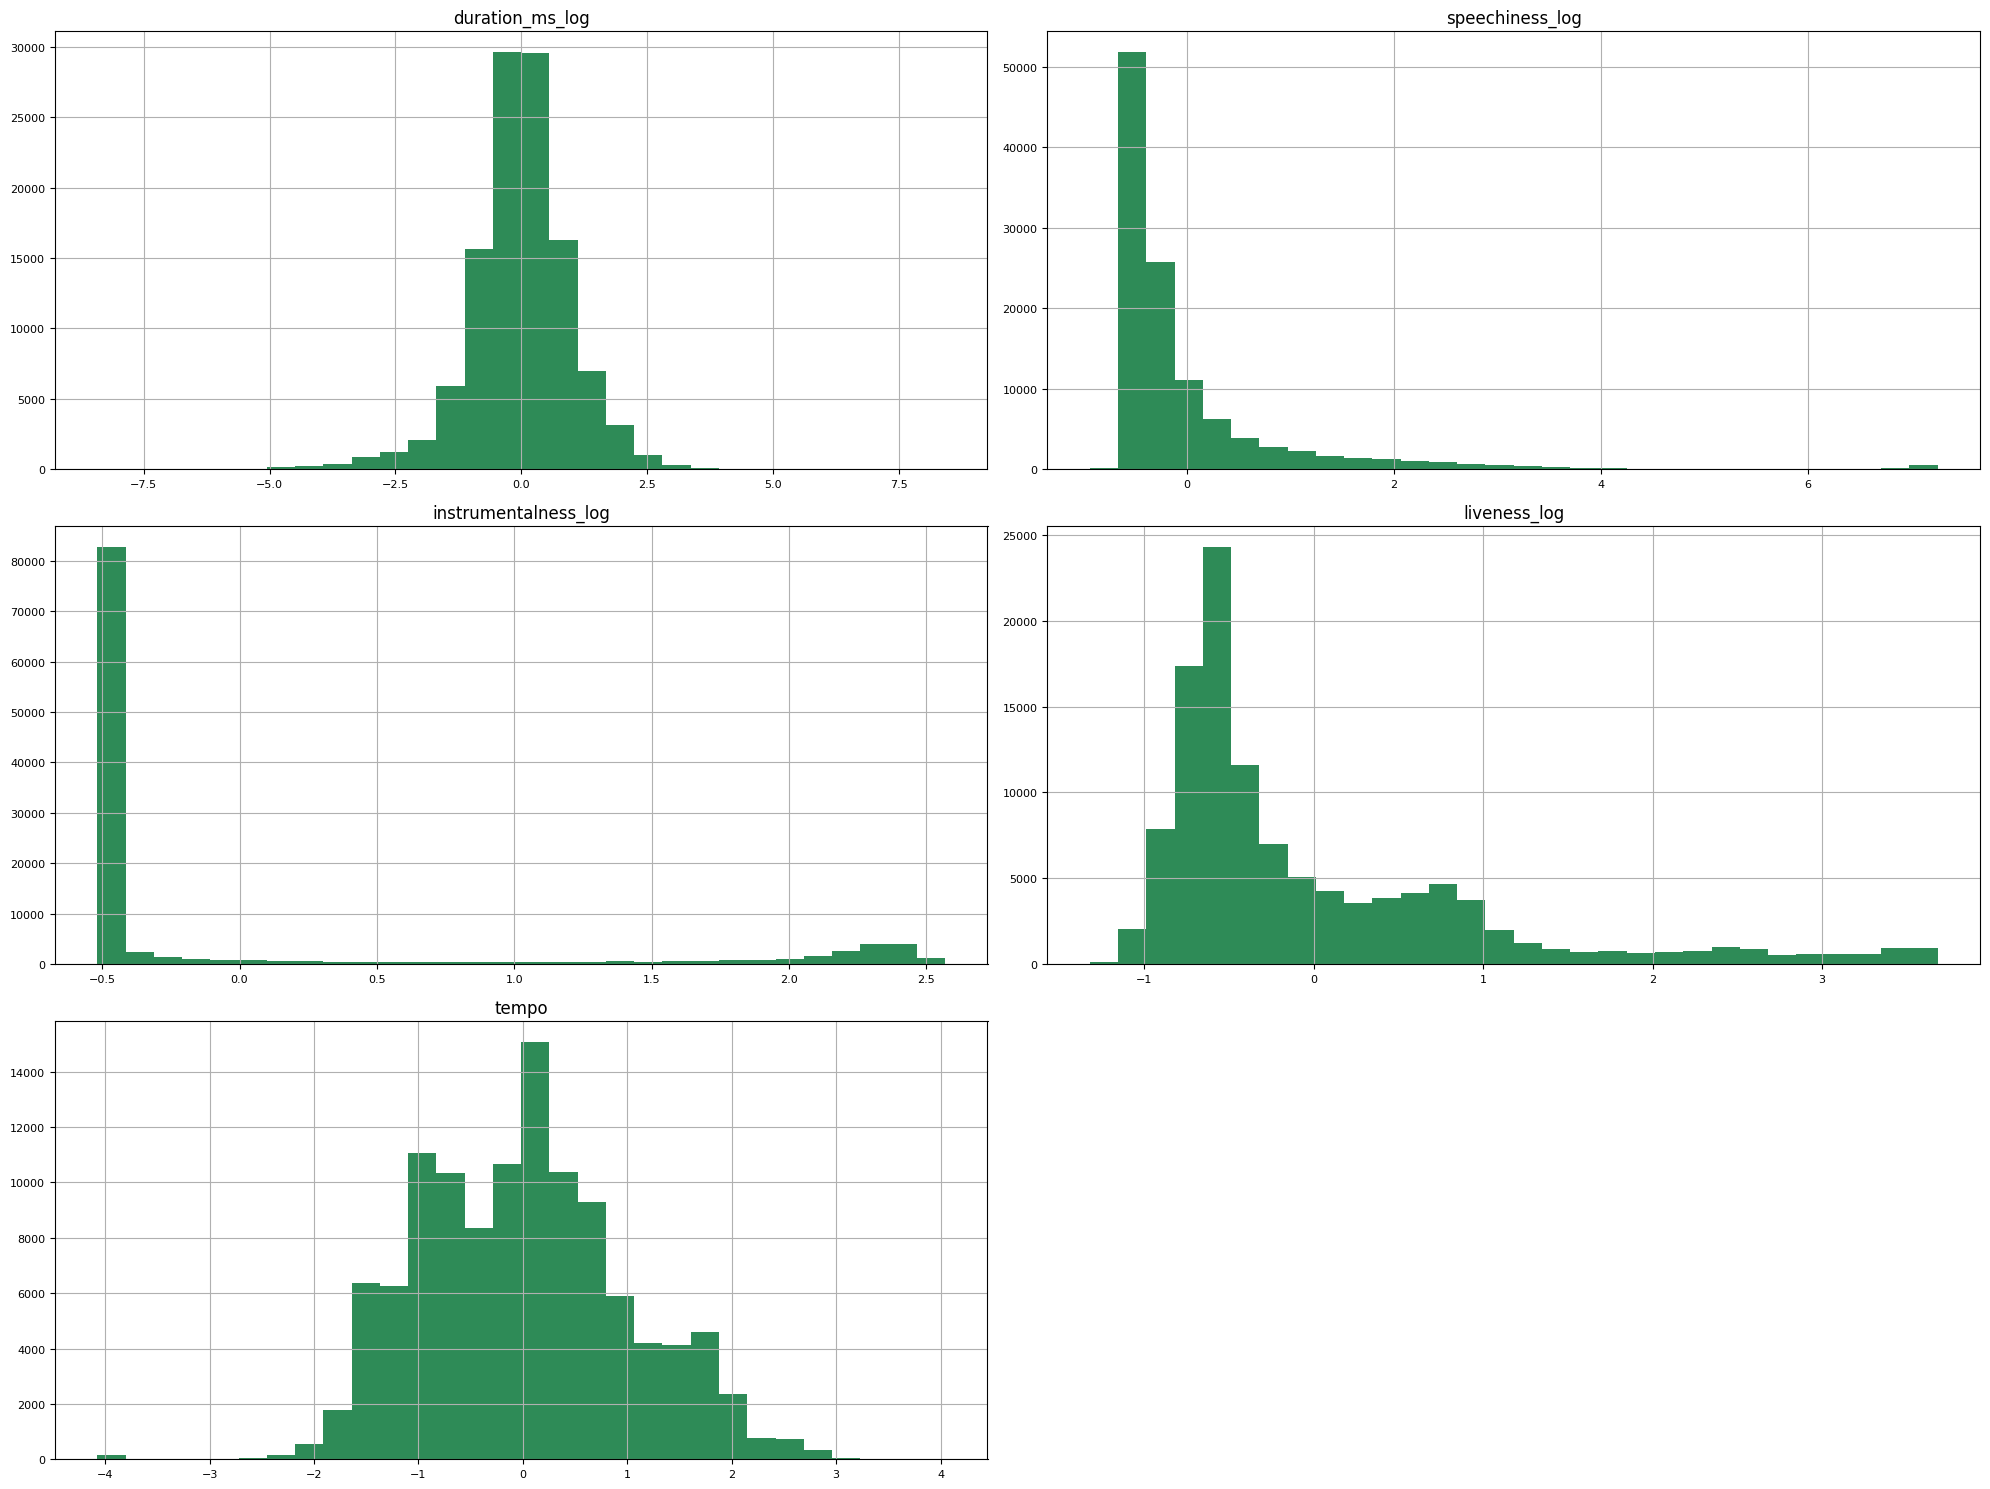

In [30]:
df_scaled.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8, color='seagreen')
plt.tight_layout()
plt.show()

In [31]:
df_linear = df_features.copy()
df_linear = df_linear.drop(log_features, axis=1)
df_linear = pd.concat([df_linear, df_scaled], axis=1)
df_linear

,danceability,energy,valence,tempo,explicit,tempo_medium,tempo_fast,tempo_very_fast,duration_ms_log,speechiness_log,instrumentalness_log,liveness_log,tempo
0,0.676,0.4610,0.7150,87.917,0,False,False,False,0.220962,0.681490,-0.517925,0.886884,-1.142994
1,0.420,0.1660,0.2670,77.489,0,False,False,False,-0.916420,-0.048194,-0.517905,-0.628200,-1.490909
2,0.438,0.3590,0.1200,76.332,0,False,False,False,-0.015315,-0.282719,-0.517930,-0.524007,-1.529510
3,0.266,0.0596,0.1430,181.740,0,False,False,True,-0.128536,-0.507804,-0.517615,-0.427672,1.987275
4,0.618,0.4430,0.1670,119.949,0,True,False,False,-0.168915,-0.318407,-0.517930,-0.747909,-0.074292
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113544,0.172,0.2350,0.0339,125.995,0,False,True,False,1.566760,-0.438907,2.405398,-0.725271,0.127424
113545,0.174,0.1170,0.0350,85.239,0,False,False,False,1.566767,-0.463385,2.514904,-0.602010,-1.232341
113546,0.629,0.3290,0.7430,132.378,0,False,True,False,0.648832,-0.441237,-0.517930,-0.741244,0.340384
113547,0.587,0.5060,0.4130,135.960,0,False,True,False,0.766423,-0.585341,-0.517930,0.403054,0.459892
